# Ephaptic Coupling model analysis

Some experiments to (better) understand the model

In [1]:
import matplotlib.pyplot as plt
from scipy import signal, special
from collections import Counter
import pandas as pd

In [2]:
from matplotlib import rcParams
rcParams.update({
    'font.family': 'serif',
})

In [3]:
import attr
import numpy as np

# SI base units
s = 1
kg = 1
m = 1
A = 1

# derived units
S = s**3*A**2/(kg*m**2)
V = kg*m**2*s**-3*A**-1
F = s**4 * A**2 * m**-2 * kg ** -1
Hz = 1/s

# with prefixes
nS = 1e-9 * S
uS = 1e-6 * S
mV = 1e-3 * V
uV = 1e-6 * V
pF = 1e-12 * F
ms = 1e-3 * s
nA = 1e-9 * A
pA = 1e-12 * A


def kuhn_transfer_function(threshold, tau_eff, mu_u, sigma_sq_u):
    return 1. / (2 * tau_eff) * (special.erfc((threshold - mu_u) /
                                 (np.sqrt(2) * np.sqrt(sigma_sq_u))))


def derivative_kuhn_transfer_function(threshold, tau_eff,  mu_u, sigma_sq_u):
    return 1. / (2 * tau_eff * (np.sqrt(2 * sigma_sq_u)) * (2/ np.sqrt(np.pi)) *
                 np.exp(-(threshold - mu_u) ** 2 / (2 * sigma_sq_u)))


@attr.s
class EIMeanField:
    E_e = attr.ib(0 * mV)
    E_i = attr.ib(-75 * mV)
    E_l = attr.ib(-70 * mV)
    g_l = attr.ib(1./60 * uS)
    C = attr.ib(250 * pF)
    v_reset = attr.ib(-60 * mV)
    threshold = attr.ib(-50 * mV)
    threshold_inh = attr.ib(-53 * mV)
    tau_ref = attr.ib(2 * ms)
    T_e = attr.ib(0.2 * ms)  # width of excitatory PSC (ms)
    T_i = attr.ib(2 * ms)    # width of inhibitory PSC (ms)
    tau_e = attr.ib(1 * ms)  # timescale of excitatory population (ms)
    tau_i = attr.ib(0.5 * ms)    # timescale of inhibitory population (ms)
    B_e = attr.ib(7.1 * nS)    # peak excitatory conductance (nS)
    B_i = attr.ib(3.7 * nS)    # peak inhibitory conductance (nS)

    f_ext = attr.ib(5000 * Hz) # extracellular_firing_rate

    n_e = attr.ib(350.) # number of excitatory neurons
    n_i = attr.ib(350. / 4.) # number of inhibitory neurons

    noise_std_e = attr.ib(2000 * Hz / np.sqrt(s))
    noise_std_i = attr.ib(0 * Hz / np.sqrt(s))

    tau_adapt = attr.ib(800 * ms) # adaptation time constant
    beta_adapt = attr.ib(0.00005*mV / Hz) # strength of adaptation (per firing rate of E population)

    def calc_membrane_stats(self, fr_e, fr_i):

        mu_ge = fr_e * self.B_e * self.T_e * np.exp(1)
        mu_gi = fr_i * self.B_i * self.T_i * np.exp(1)

        gtot = self.g_l + mu_ge + mu_gi

        mu_u = (self.E_l * self.g_l + self.E_e * mu_ge + self.E_i * mu_gi) / gtot

        tau_eff = self.C / gtot

        epsp_int = (self.E_e - mu_u) * self.B_e * self.T_e * np.exp(1) * tau_eff / self.C
        ipsp_int = (self.E_i - mu_u) * (self.B_i * self.T_i * np.exp(1) * tau_eff / self.C)
        epsp_sq =  epsp_int ** 2 * (2 * tau_eff + self.T_e) /(4 * (tau_eff + self.T_e)**2)
        ipsp_sq =  ipsp_int ** 2 * (2 * tau_eff + self.T_i) /(4 * (tau_eff + self.T_i)**2)
        sigma_sq_u = fr_e * epsp_sq + fr_i * ipsp_sq

        return gtot, mu_u, tau_eff, sigma_sq_u


    def calc_output_rate_inh_exc(self, fr_e, fr_i, delta_v_e=0, delta_v_i=0):
        gtot_exc, mu_u_exc, tau_eff_exc, sigma_sq_u_exc = \
                        self.calc_membrane_stats(fr_e=fr_e, fr_i=fr_i)
        gtot_inh, mu_u_inh, tau_eff_inh, sigma_sq_u_inh = \
                        self.calc_membrane_stats(fr_e=fr_e, fr_i=fr_i)

        rexc = kuhn_transfer_function(self.threshold + delta_v_e, tau_eff_exc, mu_u_exc, sigma_sq_u_exc)
        rinh = kuhn_transfer_function(self.threshold_inh + delta_v_i, tau_eff_inh, mu_u_inh, sigma_sq_u_inh)

        return rexc * self.n_e, rinh * self.n_i

    def ode_step(self, dt, rexc, rinh, theta_adapt, dv_e=0, dv_i=0):
        fexc, finh = self.calc_output_rate_inh_exc(rexc + self.f_ext,
                              rinh, theta_adapt + dv_e, dv_i)
        theta_adapt = theta_adapt + ((-theta_adapt +
                 self.beta_adapt * rexc) *
                 dt / self.tau_adapt)
        rinh = rinh + (-rinh + finh) * dt / self.tau_i
        rexc = rexc + (-rexc + fexc) * dt / self.tau_e

        return rexc, rinh, theta_adapt

    def sde_step(self, dt, rexc, rinh, theta_adapt, dv_e=0, dv_i=0):
        rexc, rinh, theta_adapt = self.ode_step(dt, rexc, rinh, theta_adapt, dv_e, dv_i)
        rexc += np.random.randn() * self.noise_std_e * np.sqrt(dt)
        rinh += np.random.randn() * self.noise_std_i * np.sqrt(dt)
        rexc = np.maximum(rexc, 0)
        rinh = np.maximum(rinh, 0)

        return rexc, rinh, theta_adapt

### 1.Running the model

In [4]:
# parameters and init
tau_adapt = 800 * ms # adaptation time constant
beta_adapt = 0.00005*mV / Hz # strength of adaptation (per firing rate of E population) # Try diff. betas (transition around 20 (?))
dt = 1. * ms # integration time step
tau_e = 10*ms # time constant of excitatory population
tau_i = 5* ms # time constant of inhibitory population
threshold_inh0 = -51 * mV # inhibitory threshold
noise_e = 2000 * Hz / s 
tmax = 20 * s
f_ext = 1000 * Hz

model = EIMeanField(tau_adapt=tau_adapt,
                    beta_adapt=beta_adapt,
                    tau_e=tau_e,
                    tau_i=tau_i,
                    threshold_inh=threshold_inh0,
                    noise_std_e=noise_e,
                    noise_std_i=noise_e/4,
                    f_ext=f_ext
                    )

In [5]:
# running simulation
np.random.seed(100)
rexc = 100 * Hz
rinh = 100 * Hz
theta_adapt = 0 * mV
gamma = 0 * uV # in theory V/m
dt = 1*ms
t = 0
solution = []
while t < tmax:
    rexc, rinh, theta_adapt = model.sde_step(dt, rexc, rinh, theta_adapt, gamma)
    t += dt
    solution.append((rexc, rinh, theta_adapt))
solution = np.array(solution)
time = np.arange(solution.shape[0]) * dt

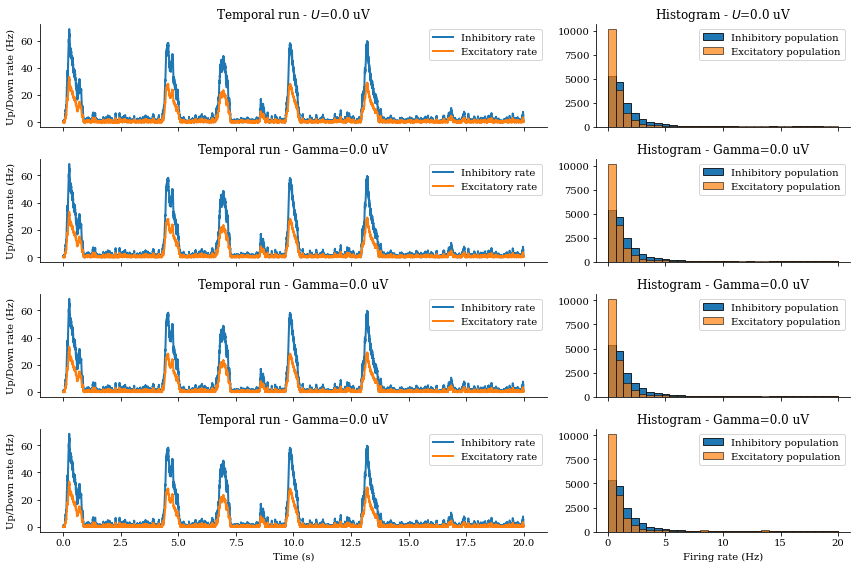

In [6]:
# plot
def plot_single_hist(time, solution, title, thr=90, bins=30, savefig=None, ax0=None, ax1=None):
    #fig, ax = plt.subplots(1,2,figsize=(10,3), gridspec_kw={'width_ratios': [2, 1.2]})
    
    exc = solution[:,0]/model.n_e
    inh = solution[:,1]/model.n_i
    
    l2 = ax0.plot(time, solution[:,1]/model.n_i, label="Inhibitory rate", lw=2.0)[0]
    l1 = ax0.plot(time, solution[:,0]/model.n_e, label="Excitatory rate", lw=2.0)[0]
    
    ax1.hist(inh[inh < thr], bins=bins, edgecolor='black', label="Inhibitory population", lw=0.8, alpha=1.0)
    ax1.hist(exc[exc < thr], bins=bins, edgecolor='black', label="Excitatory population", lw=0.8, alpha=0.7)
    
    lines = [l2,l1]
    
    ax0.legend(lines, [l.get_label() for l in lines])
    ax0.set(title=f"Temporal run - {title}",
           #xlabel="Time (s)",
           ylabel="Up/Down rate (Hz)")
    #ax0.grid()
    
    ax1.set(title=f"Histogram - {title}",)
       #xlabel="Firing rate (Hz)")
    ax1.legend()
    
    #ax0.set_frame_on(False)
    #ax1.set_frame_on(False)
    
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    
fig, ax = plt.subplots(4,2,figsize=(12,8), gridspec_kw={'width_ratios': [2, 1]}, sharex="col")

plot_single_hist(time, solution, title=f'$U$={gamma/uV} uV', thr=20, ax0=ax[0,0], ax1=ax[0,1])
plot_single_hist(time, solution, title=f'Gamma={gamma/uV} uV', thr=20, ax0=ax[1,0], ax1=ax[1,1])
plot_single_hist(time, solution, title=f'Gamma={gamma/uV} uV', thr=20, ax0=ax[2,0], ax1=ax[2,1])
plot_single_hist(time, solution, title=f'Gamma={gamma/uV} uV', thr=20, ax0=ax[3,0], ax1=ax[3,1])

ax[3,0].set(xlabel="Time (s)")
ax[3,1].set(xlabel="Firing rate (Hz)")

fig.tight_layout()

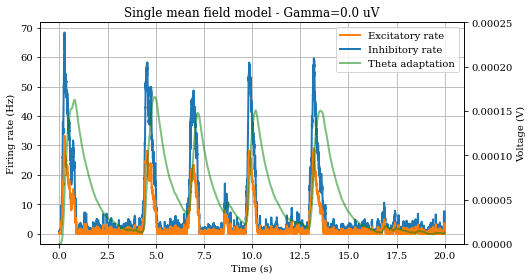

In [7]:
# plot
def plot_single(time, solution, title, savefig=None):
    fig, ax = plt.subplots(figsize=(7.5,4))

    l2 = ax.plot(time, solution[:,1]/model.n_i, label="Inhibitory rate", lw=2.0)[0]
    l1 = ax.plot(time, solution[:,0]/model.n_e, label="Excitatory rate", lw=2.0)[0]

    ax2 = ax.twinx()
    ax2.set_ylim([0.0,0.00025])
    l3 = ax2.plot(time, solution[:,2], label="Theta adaptation", lw=2.0,alpha=0.5, c='green')[0]

    lines = [l1,l2,l3]

    ax.legend(lines, [l.get_label() for l in lines])
    ax.set(title=title,
           xlabel="Time (s)",
           ylabel="Firing rate (Hz)")
    ax2.set(ylabel="Voltage (V)")
    ax.grid()
    
    fig.tight_layout()

    fig.show()

    if savefig:
        fig.savefig(f'./img/{savefig}', dpi=300)
    
plot_single(time, solution, title=f'Single mean field model - Gamma={gamma/uV} uV',savefig='0gamma_single.png')

### 2.Single population with exogenous current (simple gamma addition)

In [8]:
# parameters and init
model_params = {
'tau_adapt': 800 * ms, # adaptation time constant
'beta_adapt': 0.00005*mV / Hz, # strength of adaptation (per firing rate of E population)
'tau_e': 10*ms, # time constant of excitatory population
'tau_i': 5* ms, # time constant of inhibitory population
'threshold_inh': -51 * mV, # inhibitory threshold
'noise_std_e': 2000 * Hz / s, 
'noise_std_i': 0,
'f_ext': 1000 * Hz,
}

model = EIMeanField(**model_params)

In [9]:
# running simulation
simulation_params = {
    'seed': 100,
    'rexc': 100*Hz,
    'rinh': 100*Hz,
    'theta_adapt': 0*mV,
    'gamma': 0*uV,
    'dt': 1*ms,
    'tmax': 20*s,
} 

def run_single(model, seed=100, rexc_i=100*Hz, rinh_i=100*Hz, theta_i=0*mV, gamma=0*uV, dt=1*ms, tmax=20*s):
    np.random.seed(100)
    
    rexc = rexc_i
    rinh = rinh_i
    theta = theta_i
    
    t = 0
    solution = []
    while t < tmax:
        rexc, rinh, theta = model.sde_step(dt, rexc, rinh, theta, gamma)
        t += dt
        solution.append((rexc, rinh, theta))
    solution = np.array(solution)
    time = np.arange(solution.shape[0]) * dt
    
    return time, solution



**Positive gamma** There are less peaks

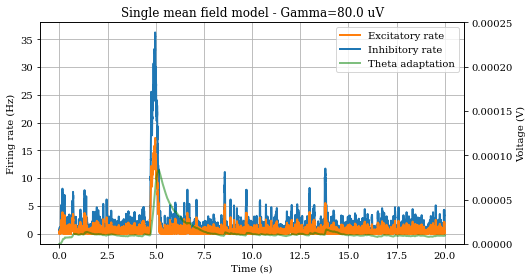

In [15]:
time, solution80 = run_single(model, gamma=80*uV)
plot_single(time, solution80, title=f'Single mean field model - Gamma={80.0} uV',savefig='80gamma_single.png')

**Negative gamma** There are more peaks

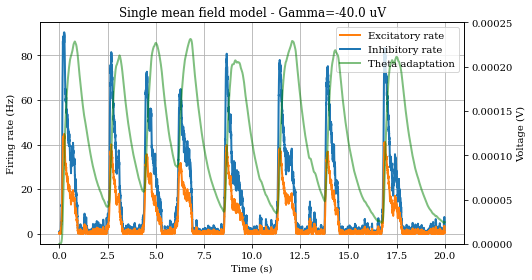

In [16]:
time, neg80solution = run_single(model, gamma=-80*uV)
plot_single(time, neg80solution, title=f'Single mean field model - Gamma={-40.0} uV',savefig='-40gamma_single.png')

**Positive (big) gamma** There are no peaks

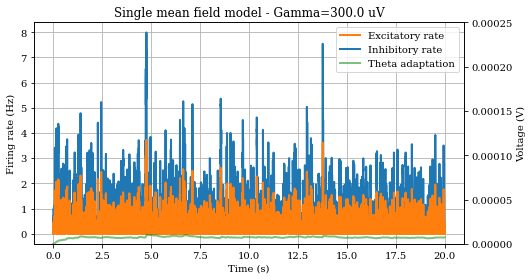

In [17]:
time, solution300 = run_single(model, gamma=300*uV)
plot_single(time, solution300, title=f'Single mean field model - Gamma={300.0} uV',savefig='300gamma_single.png')

**Negative (big) gamma** One big peak and then saturation at 10k hz for excitatory and 5k hz for inhibitory

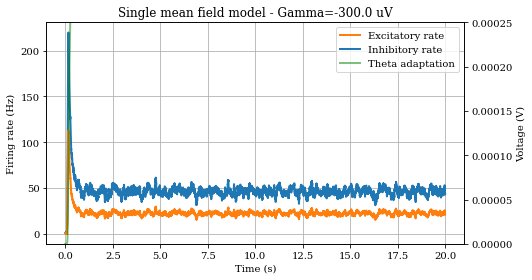

In [18]:
time, neg300solution = run_single(model, gamma=-300*uV)
plot_single(time, neg300solution, title=f'Single mean field model - Gamma={-300.0} uV',savefig='-300gamma_single.png')

Big report plot

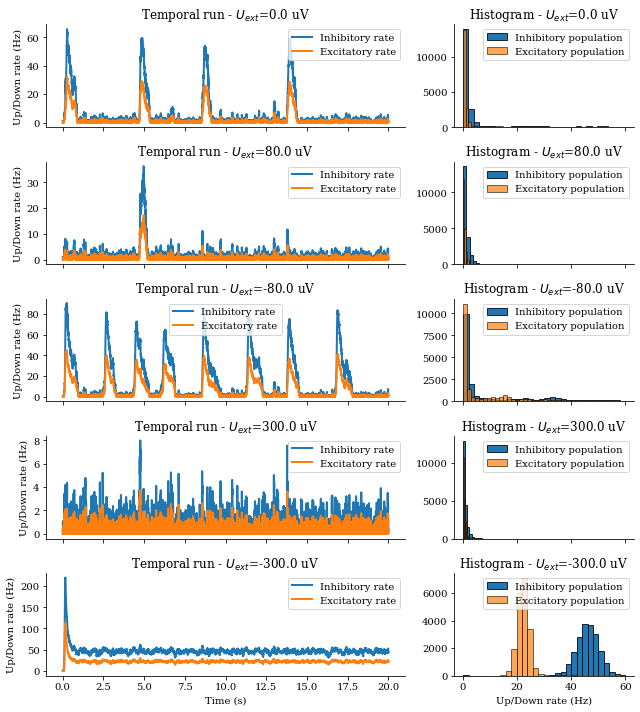

In [23]:
fig, ax = plt.subplots(5,2,figsize=(9,10), gridspec_kw={'width_ratios': [2, 1]}, sharex="col")

plot_single_hist(time, solution, title=r'$U_{ext}$=0.0 uV', thr=60, ax0=ax[0,0], ax1=ax[0,1])
plot_single_hist(time, solution80, title=r'$U_{ext}$=80.0 uV', thr=60, ax0=ax[1,0], ax1=ax[1,1])
plot_single_hist(time, neg80solution, title=r'$U_{ext}$=-80.0 uV', thr=60, ax0=ax[2,0], ax1=ax[2,1])
plot_single_hist(time, solution300, title=r'$U_{ext}$=300.0 uV', thr=60, bins=10, ax0=ax[3,0], ax1=ax[3,1])
plot_single_hist(time, neg300solution, title=r'$U_{ext}$=-300.0 uV', thr=60, ax0=ax[4,0], ax1=ax[4,1])

ax[4,0].set(xlabel="Time (s)")
ax[4,1].set(xlabel="Up/Down rate (Hz)")

fig.tight_layout()
fig.savefig(f'./img/simple_gamma.pdf', dpi=300)

### 3.Gamma-Frequency plot

Frequency detector with hysteresis

In [15]:
# Frequency detector with hysteresis
time, solution = run_single(model, gamma=-85*uV, tmax=40*s)

There are 17 peaks


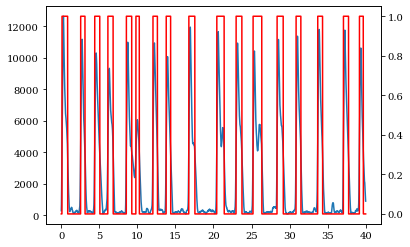

In [16]:
from collections import Counter

# 1.moving average
sol = solution[:,0]
sol = np.convolve(sol, np.ones(250), 'same')/250
# 2.threshold the signal
thr = sol>4000
# 3.count ascending jumps
values = thr.astype('int')
# 3.1 Computes the crossing 1: ascendent -1: descendent
difference = values[1:]-values[:-1]
# 3.2 Count the number of 1 (ascendent crossings)
peaks = Counter(difference)[1]

plt.plot(time[:], sol[:])
plt.twinx()
plt.plot(time[:], thr[:],c='r')

print(f"There are {peaks} peaks")

In [17]:
def count_peaks(signal, thr_val=4000, ones=250):
    # 1.moving average
    signal = signal
    signal = np.convolve(signal, np.ones(ones))/ones
    # 2.threshold the signal
    thr = signal>thr_val
    # 3.count ascending jumps
    values = thr.astype('int')
    # 3.1 Computes the crossing 1: ascendent -1: descendent
    difference = values[1:]-values[:-1]
    # 3.2 Count the number of 1 (ascendent crossings)
    peaks = Counter(difference)[1]
    return peaks

Run experiments

In [28]:
def write(fn, string, t="a"):
    f = open(fn, t)
    f.write(string)
    f.close()

In [16]:
# params
fn = "gamma_results.txt"
time = 500*s # (!)
gammas = np.linspace(-300,150,100)*uV
#seeds = np.linspace(1000,100000,10,dtype=int)
seeds = [100]

write(fn,"gamma,seed,frequency\n",t="w")

for gamma in gammas:
    current = 0
    for seed in seeds:
        _ , solution = run_single(model, seed=seed, gamma=gamma, tmax=time)
        frequency = count_peaks(solution[:,0])/time
        current += frequency
        
        write(fn,f"{gamma}, {seed}, {frequency} \n")
        
        print(".", end="")
        #print(f"Gamma = {gamma/uV:2f} uV - Seed = {seed} - Frequency = {frequency} Hz")
    
    print(f"\nGamma = {gamma/uV:.3f} uV - Frequency (avg) = {current/10:.3f} Hz")



.
Gamma = -300.000 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -295.455 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -290.909 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -286.364 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -281.818 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -277.273 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -272.727 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -268.182 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -263.636 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -259.091 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -254.545 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -250.000 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -245.455 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -240.909 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -236.364 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -231.818 uV - Frequency (avg) = 0.001 Hz
.
Gamma = -227.273 uV - Frequency (avg) = 0.001 Hz
.
Gamma = -222.727 uV - Frequency (avg) = 0.002 Hz
.
Gamma = -218.182 uV - Frequency (avg) = 0.002 Hz
.
Gamma = -213.636 uV - Frequen

Results analysis and plot

In [135]:
import pandas as pd

In [24]:
file_name = "1_gamma_results.txt"
results = pd.read_csv(file_name)

In [25]:
results.head()

,gamma,seed,frequency
0,-0.000300,100,0.002
1,-0.000295,100,0.002
2,-0.000291,100,0.002
3,-0.000286,100,0.002
4,-0.000282,100,0.002


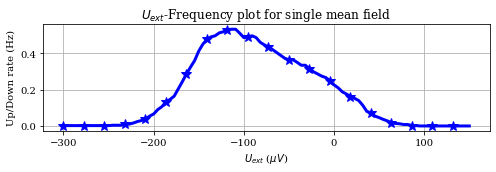

In [27]:
# plot
fig, ax = plt.subplots(figsize=(7,2.5))
ax.plot(results.gamma/uV, results.frequency, label="Synchronization rate", lw=3.0, c='b', marker="*", markevery=5, ms=10)[0]

ax.set(title=r"$U_{ext}$-Frequency plot for single mean field ",
       xlabel=r"$U_{ext}$ ($\mu V$)",
       ylabel="Up/Down rate (Hz)")
ax.grid()

fig.show()
fig.tight_layout()

#ax.set_frame_on(False)
    
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)

fig.savefig('./img/gamma-frequency_single.pdf', dpi=300)

In [102]:
# compute 95p confidence intervals (NO)

### 4.Two (ephaptically) coupled populations

In [10]:
def run_two_coupled_populations(model, gamma_ephaptic, init = [0,0,0], external = 0*uV, dt=1*ms, tmax=20*s, seed=100):
    np.random.seed(seed)

    states = np.zeros((2, 3))
    states[:, 0] = init[0]
    states[:, 1] = init[1]
    states[:, 2] = init[2]*uV
    
    t = 0
    solution = []
    while t < tmax: # sde_step(dt, rexc, rinh) usamos los r_inh del otro modelop para el coupling
        states[0, :] = model.sde_step(dt, *states[0, :], -states[1, 0] * gamma_ephaptic + external) #last parameter is d_
        states[1, :] = model.sde_step(dt, *states[1, :], -states[0, 0] * gamma_ephaptic + external)
        t += dt
        solution.append(states.copy())
        
    solution = np.array(solution)
    time = np.arange(solution.shape[0]) * dt
    return time, solution

In [11]:
gamma_ephaptic = 0*uV / (6000*Hz) # ephaptic coupling coefficient
tmax = 20*s
seed = 100
thr = 4000 # Just for the analysis
time, solution1 = run_two_coupled_populations(model, gamma_ephaptic, init=[0,0,0], tmax=tmax, seed=seed)

In [12]:
gamma_ephaptic = 40*uV / (6000*Hz) # ephaptic coupling coefficient
tmax = 20*s
seed = 100
thr = 4000 # Just for the analysis
time, solution2 = run_two_coupled_populations(model, gamma_ephaptic, init=[100,100,1000], tmax=tmax, seed=seed*11)

Simple plot

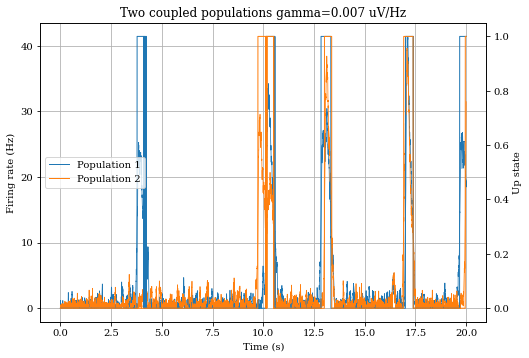

In [13]:
# plot (excitatory) signal
fig, ax = plt.subplots(figsize=(8,5.5))
ax.plot(time, solution2[:,0,0]/model.n_e, lw=0.75)
ax.plot(time, solution2[:,1,0]/model.n_e, lw=0.75)

# plot state
ax2 = ax.twinx()
ax2.plot(time, solution2[:,0,0]>thr, label="Population 1", lw=1, c="tab:blue")
ax2.plot(time, solution2[:,1,0]>thr, label="Population 2", lw=1, c="tab:orange")

# details
ax2.legend()
ax.grid()
ax.set(title=f"Two coupled populations gamma={gamma_ephaptic/uV:.3f} uV/Hz",
       xlabel="Time (s)",
       ylabel="Firing rate (Hz)")
ax2.set(ylabel="Up state")

fig.show()

Complex plot

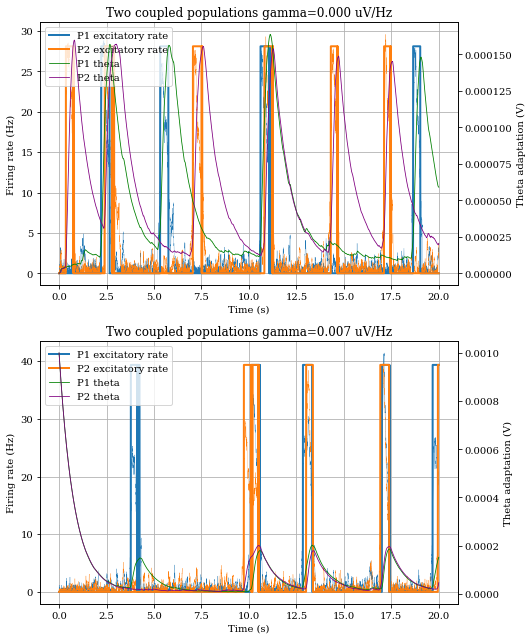

In [14]:
# plot (excitatory) signal
t1 = 20
n = int(t1/dt)

fig, ax = plt.subplots(2,1, figsize=(7.5,9))

ax[0].plot(time[:n], solution1[:n,0,0]/model.n_e, lw=0.25)
ax[0].plot(time[:n], solution1[:n,1,0]/model.n_e, lw=0.25)

# plot state
l1 = ax[0].plot(time[:n], 0.95*np.max(solution1/model.n_e)*(solution1[:n,0,0]>thr), label="P1 excitatory rate", lw=2, c="tab:blue")[0]
l2 = ax[0].plot(time[:n], 0.95*np.max(solution1/model.n_e)*(solution1[:n,1,0]>thr), label="P2 excitatory rate", lw=2, c="tab:orange")[0]

# plot 
ax2 = ax[0].twinx()
l3 = ax2.plot(time[:n], solution1[:n,0,2], label="P1 theta", lw=0.8, c="green")[0]
l4 = ax2.plot(time[:n], solution1[:n,1,2], label="P2 theta", lw=0.8, c="purple")[0]

# details
lines = [l1,l2,l3,l4]
ax[0].legend(lines, [l.get_label() for l in lines],loc=2)
ax[0].set(title=f"Two coupled populations gamma={0.0/uV:.3f} uV/Hz",
       xlabel="Time (s)",
       ylabel="Firing rate (Hz)")
ax2.set(ylabel="Theta adaptation (V)")
ax[0].grid()

ax[1].plot(time[:n], solution2[:n,0,0]/model.n_e, lw=0.25)
ax[1].plot(time[:n], solution2[:n,1,0]/model.n_e, lw=0.25)

# plot state
l1 = ax[1].plot(time[:n], 0.95*np.max(solution2/model.n_e)*(solution2[:n,0,0]>thr), label="P1 excitatory rate", lw=2, c="tab:blue")[0]
l2 = ax[1].plot(time[:n], 0.95*np.max(solution2/model.n_e)*(solution2[:n,1,0]>thr), label="P2 excitatory rate", lw=2, c="tab:orange")[0]

# plot 
ax2 = ax[1].twinx()
l3 = ax2.plot(time[:n], solution2[:n,0,2], label="P1 theta", lw=0.8, c="green")[0]
l4 = ax2.plot(time[:n], solution2[:n,1,2], label="P2 theta", lw=0.8, c="purple")[0]

# details
lines = [l1,l2,l3,l4]
ax[1].legend(lines, [l.get_label() for l in lines],loc=2)
ax[1].set(title=f"Two coupled populations gamma={40*uV / (6000*Hz)/uV:.3f} uV/Hz",
       xlabel="Time (s)",
       ylabel="Firing rate (Hz)")
ax2.set(ylabel="Theta adaptation (V)")
ax[1].grid()


fig.show()
fig.tight_layout()
fig.savefig('./img/coupled_pops.pdf', dpi=300)

Results analysis

In [28]:
from scipy import signal, special

In [29]:
def calc_pli(solution, dt, n_subsamp=100, filter_order=5, cutoff_frequency=1):
    """Calculate the phase locking index (PLI)"""
    # subsample signal
    y = solution[::n_subsamp, :, 0].copy()
    
    # filter signal
    sampling_frequency = 1 / (dt * n_subsamp)
    b, a = signal.iirfilter(filter_order,  cutoff_frequency * 2 / sampling_frequency, btype='lowpass')
    y_filtered = signal.filtfilt(b, a, y[:], axis=0)
    phases = np.angle(signal.hilbert(y_filtered, axis=0))
    
    # calculate pairwise phase locking indice
    # Pensar bien las transformaciones de las listas con las fases
    pli = np.abs(np.mean(np.exp((phases[:, :, None] - phases[:, None, :])*1j), axis=0))
    
    # zero out the diagonal for better visualisation
    ij = np.arange(pli.shape[0])
    #pli[ij, ij] = np.NaN
    return pli

In [24]:
p1_freq = count_peaks(solution[:,0,0])/tmax
p2_freq = count_peaks(solution[:,1,0])/tmax

p1_mean = np.mean(solution[:,0,0]>thr)
p2_mean = np.mean(solution[:,1,0]>thr)

corr_coef = np.corrcoef(solution[:,:,0].T>thr)[0,1]
pli = calc_pli(solution,dt)[0,1]

In [17]:
print(f"Seed={seed}, Coupling={gamma_ephaptic/uV:.3f} uV/Hz, P1 freq={p1_freq:.3f} Hz, P2 freq={p2_freq:.3f} Hz, P1 mean={p1_mean:.3f}, P2 mean={p2_mean:.3f}, Corr coef={corr_coef:.3f}, PLI={pli:.3f}")

Seed=100, Coupling=0.011 uV/Hz, P1 freq=0.250 Hz, P2 freq=0.350 Hz, P1 mean=0.103, P2 mean=0.137, Corr coef=0.426, PLI=0.422


Run experiments

In [45]:
# params
fn = "./results/coupling_results.txt"
tmax = 400*s # (!)
couplings = np.linspace(0, 65. * uV / (6000*Hz), 30)
# seeds = np.linspace(100,100000,10,dtype=int)
seeds = [1000]

write(fn,"coupling,seed,p1freq,p1mean,p2freq,p2mean,corr,pli\n",t="w")

for gamma_ephaptic in couplings:
    current = 0
    print(f"\nCurrent gamma coupling == {gamma_ephaptic/uV:.5f} uV/Hz")
    for seed in seeds:
        _ , solution = run_two_coupled_populations(model, gamma_ephaptic, tmax=tmax, seed=seed)
        
        p1_freq = count_peaks(solution[:,0,0])/tmax
        p2_freq = count_peaks(solution[:,1,0])/tmax

        p1_mean = np.mean(solution[:,0,0]>thr)
        p2_mean = np.mean(solution[:,1,0]>thr)

        corr_coef = np.corrcoef(solution[:,:,0].T>thr)[0,1]
        pli = calc_pli(solution,dt)[0,1]       
        
        write(fn,f"{gamma_ephaptic}, {seed}, {p1_freq}, {p1_mean}, {p2_freq}, {p2_mean}, {corr_coef}, {pli}\n")

        print(".",end="")
        #print(f"Coupling={gamma_ephaptic/uV:.3f} uV/Hz, Seed={seed}, P1 freq={p1_freq:.3f} Hz, P2 freq={p2_freq:.3f} Hz, P1 mean={p1_mean:.3f}, P2 mean={p2_mean:.3f}, Corr coef={corr_coef:.3f}, PLI={pli:.3f}")    
    
    #print(f"Gamma = {gamma/uV:.2f} uV - Frequency (avg) = {current/10:.2f} Hz")


Current gamma coupling == 0.00000 uV/Hz
.
Current gamma coupling == 0.00037 uV/Hz
.
Current gamma coupling == 0.00075 uV/Hz
.
Current gamma coupling == 0.00112 uV/Hz
.
Current gamma coupling == 0.00149 uV/Hz
.
Current gamma coupling == 0.00187 uV/Hz
.
Current gamma coupling == 0.00224 uV/Hz
.
Current gamma coupling == 0.00261 uV/Hz
.
Current gamma coupling == 0.00299 uV/Hz
.
Current gamma coupling == 0.00336 uV/Hz
.
Current gamma coupling == 0.00374 uV/Hz
.
Current gamma coupling == 0.00411 uV/Hz
.
Current gamma coupling == 0.00448 uV/Hz
.
Current gamma coupling == 0.00486 uV/Hz
.
Current gamma coupling == 0.00523 uV/Hz
.
Current gamma coupling == 0.00560 uV/Hz
.
Current gamma coupling == 0.00598 uV/Hz
.
Current gamma coupling == 0.00635 uV/Hz
.
Current gamma coupling == 0.00672 uV/Hz
.
Current gamma coupling == 0.00710 uV/Hz
.
Current gamma coupling == 0.00747 uV/Hz
.
Current gamma coupling == 0.00784 uV/Hz
.
Current gamma coupling == 0.00822 uV/Hz
.
Current gamma coupling == 0.00859

<ipython-input-3-447f67a31b1e>:29: RuntimeWarning: divide by zero encountered in double_scalars
  return 1. / (2 * tau_eff) * (special.erfc((threshold - mu_u) /
<ipython-input-3-447f67a31b1e>:94: RuntimeWarning: overflow encountered in double_scalars
  return rexc * self.n_e, rinh * self.n_i
<ipython-input-3-447f67a31b1e>:74: RuntimeWarning: invalid value encountered in double_scalars
  mu_u = (self.E_l * self.g_l + self.E_e * mu_ge + self.E_i * mu_gi) / gtot


.

In [ ]:
# Repeat previous experiment with constant gamma

Plot results

In [153]:
file_name = "./results/1_coupling_results.txt"
results = pd.read_csv(file_name)

In [154]:
results.head()

,coupling,seed,p1freq,p1mean,p2freq,p2mean,corr,pli
0,0.000000e+00,1000,0.2175,0.087847,0.2250,0.091507,0.000139,0.187281
1,3.735632e-10,1000,0.2150,0.087657,0.2275,0.092775,0.010148,0.197863
2,7.471264e-10,1000,0.2150,0.088087,0.2275,0.092897,0.019501,0.203288
3,1.120690e-09,1000,0.2150,0.088485,0.2275,0.092752,0.037845,0.217713
4,1.494253e-09,1000,0.2225,0.091770,0.2300,0.094100,0.044067,0.227584


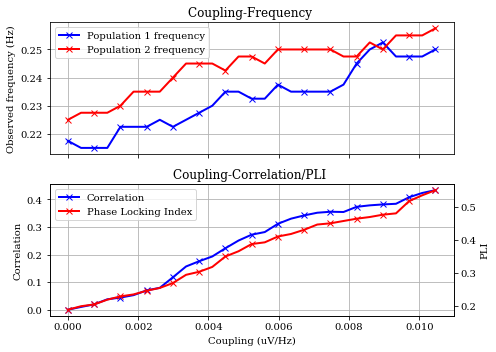

In [168]:
# plot
fig, ax = plt.subplots(2,1,figsize=(7,5), sharex="col")

ax[0].plot(results['coupling']/uV, results['p1freq'], 'x-', label="Population 1 frequency", lw=2.0, c='b', markevery=2)[0]
ax[0].plot(results['coupling']/uV, results['p2freq'], 'x-', label="Population 2 frequency", lw=2.0, c='r', markevery=2)[0]

ax[0].legend()
ax[0].set(title=f"Coupling-Frequency ",
       #xlabel="Coupling (uV/Hz)",
       ylabel="Observed frequency (Hz)")
ax[0].grid()

l1 = ax[1].plot(results['coupling']/uV, results['corr'], 'x-', label="Correlation", lw=2.0, c='b', markevery=2)[0]
ax2 = ax[1].twinx()
l2 = ax2.plot(results['coupling']/uV, results['pli'], 'x-', label="Phase Locking Index", lw=2.0, c='r', markevery=2)[0]

lines = [l1,l2]

ax[1].legend(lines, [l.get_label() for l in lines],loc=2)
ax[1].set(title=f"Coupling-Correlation/PLI ",
       xlabel="Coupling (uV/Hz)",
       ylabel="Correlation")
ax2.set(ylabel="PLI")
ax[1].grid()

fig.tight_layout()

fig.show()
fig.savefig('./img/coupling-frequency_pair.pdf', dpi=300)

In [160]:
# plot
#fig, ax = plt.subplots(figsize=(7.5,3.5))

l1 = ax[1].plot(results['coupling']/uV, results['corr'], 'x-', label="Correlation", lw=2.0, c='b', markevery=2)[0]
ax2 = ax[1].twinx()
l2 = ax2.plot(results['coupling']/uV, results['pli'], 'x-', label="Phase Locking Index", lw=2.0, c='r', markevery=2)[0]

lines = [l1,l2]

ax[1].legend(lines, [l.get_label() for l in lines],loc=2)
ax[1].set(title=f"Coupling-Correlation/PLI plot for two coupled populations ",
       xlabel="Coupling (uV/Hz)",
       ylabel="Correlation")
ax2.set(ylabel="PLI")
ax[1].grid()

fig.tight_layout()

fig.show()
#fig.savefig('./img/coupling-PLI&corr_pair.png', dpi=300)

### 5.Two coupled populations with exogenous current

In [34]:
#time, solution = run_two_coupled_populations(model, gamma_ephaptic, external=external_gamma, tmax=time, seed=seed)
#plot_single(time, solution, title=f'Single mean field model - Gamma={-300.0} uV',savefig='-300gamma_single.png')

In [113]:
# params
fn = "./results/gamma-coupling_results.txt"
time = 400*s # (!)

couplings = np.linspace(0, 60. * uV / (6000*Hz), 8)
gammas = np.linspace(-300,150,15)*uV

#seeds = np.linspace(100,100000,10,dtype=int)
seeds = [100]

write(fn,"external,coupling,seed,p1freq,p1mean,p2freq,p2mean,corr,pli\n",t="w")

for external_gamma in gammas:
    for gamma_ephaptic in couplings:
        current = 0
        print(f"\nCurrent gamma external-coupling == {external_gamma/uV:.4f}-{gamma_ephaptic/uV:.4f}")
        for seed in seeds:
            _ , solution = run_two_coupled_populations(model, gamma_ephaptic, external=external_gamma, tmax=time, seed=seed)

            p1_freq = count_peaks(solution[:,0,0])/tmax
            p2_freq = count_peaks(solution[:,1,0])/tmax

            p1_mean = np.mean(solution[:,0,0]>thr)
            p2_mean = np.mean(solution[:,1,0]>thr)

            corr_coef = np.corrcoef(solution[:,:,0].T>thr)[0,1]
            pli = calc_pli(solution,dt)[0,1]       

            #current += frequency
            write(fn,f"{external_gamma}, {gamma_ephaptic}, {seed}, {p1_freq}, {p1_mean}, {p2_freq}, {p2_mean}, {corr_coef}, {pli}\n")

            print(".",end="")
            #print(f"External={external_gamma/uV} uV, Coupling={gamma_ephaptic/uV:.3f} uV/Hz, Seed={seed}, P1 freq={p1_freq:.3f} Hz, P2 freq={p2_freq:.3f} Hz, P1 mean={p1_mean:.3f}, P2 mean={p2_mean:.3f}, Corr coef={corr_coef:.3f}, PLI={pli:.3f}")    

        #print(f"Gamma = {gamma/uV:.2f} uV - Frequency (avg) = {current/10:.2f} Hz")


Current gamma external-coupling == -300.0000-0.0000


KeyboardInterrupt: 

Data analysis

In [92]:
data = pd.read_csv("./results/1_gamma-coupling_results.txt")
data['corr'] = pd.to_numeric(data['corr'], errors='coerce')
data['pli'] = pd.to_numeric(data['pli'], errors='coerce')
data['p1freq'] = np.where(data['pli'].isna(), np.nan, data['p1freq'])
#data = data.fillna(0)

In [93]:
data.head(16)

,external,coupling,seed,p1freq,p1mean,p2freq,p2mean,corr,pli
0,-0.000300,0.000000e+00,100,0.05,0.999840,0.05,0.999808,0.911670,0.998954
1,-0.000300,1.428571e-09,100,0.05,0.999840,0.05,0.999810,0.917649,0.999108
2,-0.000300,2.857143e-09,100,0.05,0.999840,0.05,0.999810,0.917649,0.999230
3,-0.000300,4.285714e-09,100,NaN,0.002345,0.05,0.002312,0.993030,NaN
4,-0.000300,5.714286e-09,100,NaN,0.002307,0.05,0.002275,0.992917,NaN
5,-0.000300,7.142857e-09,100,NaN,0.002290,0.05,0.002262,0.993964,NaN
6,-0.000300,8.571429e-09,100,NaN,0.002280,0.05,0.002252,0.993937,NaN
7,-0.000300,1.000000e-08,100,NaN,0.002272,0.05,0.002247,0.994472,NaN
8,-0.000268,0.000000e+00,100,0.05,0.999608,0.05,0.999473,0.362333,0.998594
9,-0.000268,1.428571e-09,100,0.05,0.999738,0.05,0.999740,0.631490,0.998831


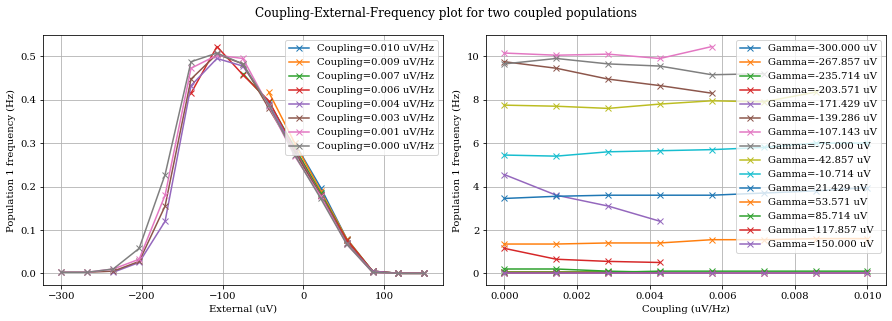

In [94]:
fig, ax = plt.subplots(1,2,figsize=(12.5,4.5))

external = data['external'].values[0::8]
couplings = data['coupling'].values[:8]

column = 'p1freq'

# first axis
for i in range(7,-1,-1):
    plis = data[column][i::8]/20 # Normalization error
    ax[0].plot(external/uV, plis, 'x-', label=f'Coupling={couplings[i]/uV:.3f} uV/Hz')
ax[0].set(xlabel="External (uV)",
       ylabel="Population 1 frequency (Hz)")
ax[0].legend(loc=1)
ax[0].grid()

# second axis
for j in range(0,15):
    plis = data[column][j*8:(j+1)*8]
    ax[1].plot(couplings/uV, plis, 'x-', label=f'Gamma={external[j]/uV:.3f} uV')

ax[1].set(xlabel="Coupling (uV/Hz)",
       ylabel="Population 1 frequency (Hz)")
ax[1].legend(loc=1)
ax[1].grid()

fig.suptitle(f"Coupling-External-Frequency plot for two coupled populations")

fig.tight_layout()

fig.show()
fig.savefig('./img/coupling-external-freq_pair.png', dpi=300)

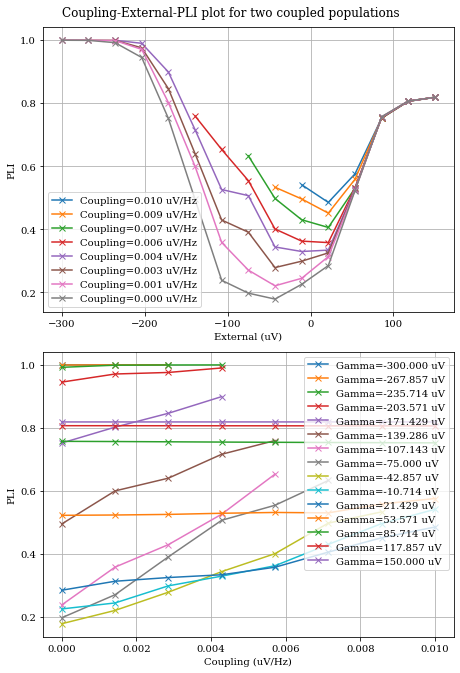

In [95]:
fig, ax = plt.subplots(2,1,figsize=(6.5,9.5))

external = data['external'].values[0::8]
couplings = data['coupling'].values[:8]

column = 'pli'

# first axis
for i in range(7,-1,-1):
    plis = data[column][i::8]
    ax[0].plot(external/uV, plis, 'x-', label=f'Coupling={couplings[i]/uV:.3f} uV/Hz')
ax[0].set(xlabel="External (uV)",
       ylabel="PLI")
ax[0].legend(loc=3)
ax[0].grid()

# second axis
for j in range(0,15):
    plis = data[column][j*8:(j+1)*8]
    ax[1].plot(couplings/uV, plis, 'x-', label=f'Gamma={external[j]/uV:.3f} uV')

ax[1].set(xlabel="Coupling (uV/Hz)",
       ylabel="PLI")
ax[1].legend(loc=1)
ax[1].grid()

fig.suptitle(f"Coupling-External-PLI plot for two coupled populations")

fig.tight_layout()

fig.show()
fig.savefig('./img/coupling-external-pli_pair.png', dpi=300)

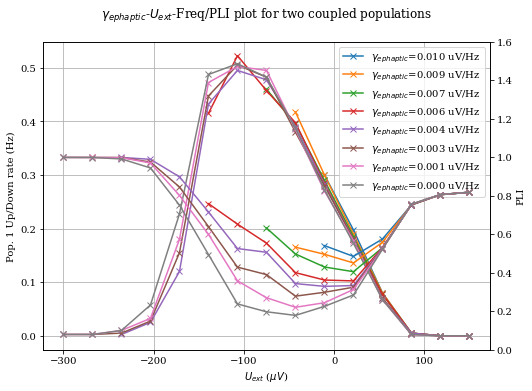

In [102]:
fig, ax = plt.subplots(1,1,figsize=(7.5,5.5))

external = data['external'].values[0::8]
couplings = data['coupling'].values[:8]

column = 'p1freq'

# first axis
for i in range(7,-1,-1):
    column = 'p1freq'
    plis = data[column][i::8]
    ax.plot(external/uV, plis/20, 'x-', label=r"$\gamma_{ephaptic}$"+f"={couplings[i]/uV:.3f} uV/Hz", alpha=1)

ax.set(xlabel=r"$U_{ext}$ ($\mu V$)",
       ylabel="Pop. 1 Up/Down rate (Hz)")
ax.legend(loc=1)

ax2 = ax.twinx()
for i in range(7,-1,-1):
    column = 'pli'
    plis = data[column][i::8]
    ax2.plot(external/uV, plis, 'x-', label=r"$\gamma_{ephaptic}$"+f"={couplings[i]/uV:.3f} uV/Hz", alpha=1)

ax2.set(xlabel=r"$U_{ext}$ ($\mu V$)",
       ylabel="PLI",
       ylim=(0,1.6))
ax.legend(loc=1)
ax.grid()



fig.suptitle(r"$\gamma_{ephaptic}$-$U_{ext}$-Freq/PLI plot for two coupled populations")

fig.tight_layout()

fig.show()
fig.savefig('./img/coupling-external-freq-pli_pair1.pdf', dpi=300)

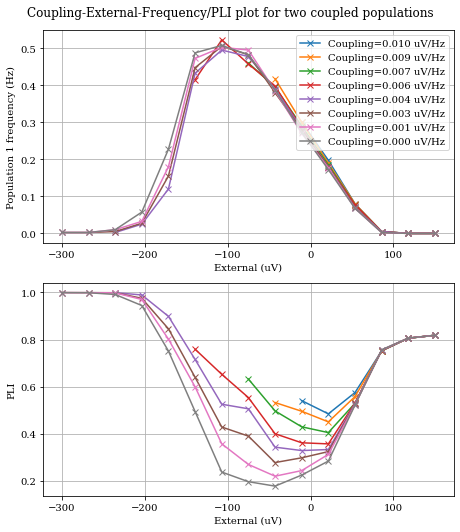

In [97]:
fig, ax = plt.subplots(2,1,figsize=(6.5,7.5))

external = data['external'].values[0::8]
couplings = data['coupling'].values[:8]

column = 'p1freq'

# first axis
for i in range(7,-1,-1):
    column = 'p1freq'
    plis = data[column][i::8]
    ax[0].plot(external/uV, plis/20, 'x-', label=f'Coupling={couplings[i]/uV:.3f} uV/Hz', alpha=1)

ax[0].set(xlabel="External (uV)",
       ylabel="Population 1 frequency (Hz)")
ax[0].legend(loc=1)
ax[0].grid()

for i in range(7,-1,-1):
    column = 'pli'
    plis = data[column][i::8]
    ax[1].plot(external/uV, plis, 'x-', label=f'Coupling={couplings[i]/uV:.3f} uV/Hz', alpha=1)

ax[1].set(xlabel="External (uV)",
       ylabel="PLI")
#ax[1].legend(loc=1)
ax[1].grid()



fig.suptitle(f"Coupling-External-Frequency/PLI plot for two coupled populations")

fig.tight_layout()

fig.show()
fig.savefig('./img/coupling-external-freq-pli_pair3.png', dpi=300)

### Beta adaptation study

In [38]:
# parameters and init
tau_adapt = 800 * ms # adaptation time constant
beta_adapt = 0.00005*mV / Hz # strength of adaptation (per firing rate of E population) # Try diff. betas (transition around 20 (?))
dt = 1. * ms # integration time step
tau_e = 10*ms # time constant of excitatory population
tau_i = 5* ms # time constant of inhibitory population
threshold_inh0 = -51 * mV # inhibitory threshold
noise_e = 2000 * Hz / s 
tmax = 20 * s
f_ext = 1000 * Hz

model = EIMeanField(tau_adapt=tau_adapt,
                    beta_adapt=beta_adapt,
                    tau_e=tau_e,
                    tau_i=tau_i,
                    threshold_inh=threshold_inh0,
                    noise_std_e=noise_e,
                    noise_std_i=0,
                    f_ext=f_ext
                    )

In [117]:
# params
fn = "./results/gamma_results.txt"
time = 500*s # (!)
gammas = np.linspace(-300,150,20)*uV
seeds = [100]

write(fn,"beta,gamma,seed,frequency\n",t="w")
#beta = beta_adapt
beta_adapt = 0.00005*mV / Hz
betas = [beta_adapt, beta_adapt/1.5, beta_adapt/2,beta_adapt/3.5, beta_adapt/5, 0., beta_adapt*1.5, beta_adapt*2]

for beta in betas:
    model = EIMeanField(tau_adapt=tau_adapt,
                    beta_adapt=beta,
                    tau_e=tau_e,
                    tau_i=tau_i,
                    threshold_inh=threshold_inh0,
                    noise_std_e=noise_e,
                    noise_std_i=0,
                    f_ext=f_ext
                    )
    for gamma in gammas:
        current = 0
        for seed in seeds:
            _ , solution = run_single(model, seed=seed, gamma=gamma, tmax=time)
            frequency = count_peaks(solution[:,0])/time
            current += frequency

            write(fn,f"{beta}, {gamma}, {seed}, {frequency} \n")

            print(".", end="")
            #print(f"Gamma = {gamma/uV:2f} uV - Seed = {seed} - Frequency = {frequency} Hz")

        print(f"\nGamma = {gamma/uV:.3f} uV - Frequency (avg) = {current/10:.3f} Hz")



.
Gamma = -300.000 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -276.316 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -252.632 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -228.947 uV - Frequency (avg) = 0.001 Hz
.
Gamma = -205.263 uV - Frequency (avg) = 0.005 Hz
.
Gamma = -181.579 uV - Frequency (avg) = 0.015 Hz
.
Gamma = -157.895 uV - Frequency (avg) = 0.033 Hz
.
Gamma = -134.211 uV - Frequency (avg) = 0.050 Hz
.
Gamma = -110.526 uV - Frequency (avg) = 0.052 Hz
.
Gamma = -86.842 uV - Frequency (avg) = 0.049 Hz
.
Gamma = -63.158 uV - Frequency (avg) = 0.040 Hz
.
Gamma = -39.474 uV - Frequency (avg) = 0.034 Hz
.
Gamma = -15.789 uV - Frequency (avg) = 0.028 Hz
.
Gamma = 7.895 uV - Frequency (avg) = 0.020 Hz
.
Gamma = 31.579 uV - Frequency (avg) = 0.011 Hz
.
Gamma = 55.263 uV - Frequency (avg) = 0.004 Hz
.
Gamma = 78.947 uV - Frequency (avg) = 0.001 Hz
.
Gamma = 102.632 uV - Frequency (avg) = 0.000 Hz
.
Gamma = 126.316 uV - Frequency (avg) = 0.000 Hz
.
Gamma = 150.000 uV - Frequency (avg) = 0.000

In [32]:
file_name = "./results/gamma_results.txt"
results = pd.read_csv(file_name)

In [33]:
results['beta'][::10]

0      5.000000e-08
10     5.000000e-08
20     3.333333e-08
30     3.333333e-08
40     2.500000e-08
50     2.500000e-08
60     1.428571e-08
70     1.428571e-08
80     1.000000e-08
90     1.000000e-08
100    0.000000e+00
110    0.000000e+00
120    7.500000e-08
130    7.500000e-08
140    1.000000e-07
150    1.000000e-07
Name: beta, dtype: float64

In [34]:
gammas = np.linspace(-300,150,20)*uV
betas = [beta_adapt, beta_adapt/1.5, beta_adapt/2,beta_adapt/3.5, beta_adapt/5, 0., beta_adapt*1.5, beta_adapt*2]

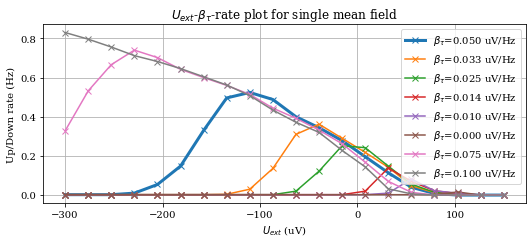

In [38]:
# plot
fig, ax = plt.subplots(figsize=(7.5,3.5))

lg = len(gammas)
for i in range(0,len(betas),1):
    column = 'frequency'
    data = results[column][i*lg:(i+1)*lg:]
    if i == 0:
        ax.plot(gammas/uV, data, 'x-', label=r"$\beta_\tau$="+f"{betas[i]/uV:.3f} uV/Hz", alpha=1, lw=3.)
    else:
        ax.plot(gammas/uV, data, 'x-', label=r"$\beta_\tau$="+f"{betas[i]/uV:.3f} uV/Hz", alpha=1)

ax.set(title=r"$U_{ext}$-$\beta_\tau$-rate plot for single mean field ",
       xlabel=r"$U_{ext}$ (uV)",
       ylabel="Up/Down rate (Hz)")
ax.grid()
ax.legend()

fig.show()
fig.tight_layout()

fig.savefig('./img/gamma-frequency_beta.pdf', dpi=300)

### Phase diagram

In [54]:
# Plot phase diagram (standard model)
model = EIMeanField(tau_adapt=tau_adapt,
                beta_adapt=beta_adapt, # beta_adapt to 0.0
                tau_e=tau_e,
                tau_i=tau_i,
                threshold_inh=threshold_inh0,
                noise_std_e=noise_e,
                noise_std_i=noise_e/4,
                f_ext=f_ext
                )
time, solution = run_single(model, gamma=-80*uV)

[Text(0.5, 1.0, 'Phase plot (exc-inh) for single mean field '),
 Text(0.5, 0, 'Excitatory rate (Hz)'),
 Text(0, 0.5, 'Inhibitory rate (Hz)')]

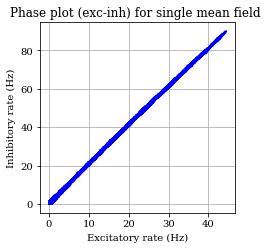

In [55]:
fig, ax = plt.subplots(figsize=(3.5,3.5))

ax.plot(solution[:,0]/model.n_e,solution[:,1]/model.n_i, lw=1.5, alpha=1., c='b')
ax.grid()

ax.set(title=f"Phase plot (exc-inh) for single mean field ",
       xlabel="Excitatory rate (Hz)",
       ylabel="Inhibitory rate (Hz)")

In [56]:
def plot_single_p(time, solution, title, savefig=None):
    # First axis
    fig, ax = plt.subplots(1,2,figsize=(10,4),gridspec_kw={'width_ratios': [6, 4]})
    l2 = ax[0].plot(time, solution[:,1]/model.n_i, label="Inhibitory rate", lw=2.0)[0]
    l1 = ax[0].plot(time, solution[:,0]/model.n_e, label="Excitatory rate", lw=2.0)[0]

    #ax2 = ax[0].twinx()
    #ax2.set_ylim([0.0,0.00025])
    #l3 = ax2.plot(time, solution[:,2], label="Theta adaptation", lw=2.0,alpha=0.5, c='green')[0]

    lines = [l1,l2]

    ax[0].legend(lines, [l.get_label() for l in lines])
    ax[0].set(title=title,
           xlabel="Time (s)",
           ylabel="Firing rate (Hz)")
    #ax2.set(ylabel="Voltage (V)")
    ax[0].grid()
    
    
    # Second axis
    ax[1].plot(solution[:,0]/model.n_e,solution[:,1]/model.n_i, lw=1.5, alpha=1., c='b')
    ax[1].grid()

    ax[1].set(title=f"Phase plot (exc-inh)",
       xlabel="Excitatory rate (Hz)",
       ylabel="Inhibitory rate (Hz)")
    
    fig.tight_layout()

    fig.show()

    if savefig:
        fig.savefig(f'./img/{savefig}', dpi=300)

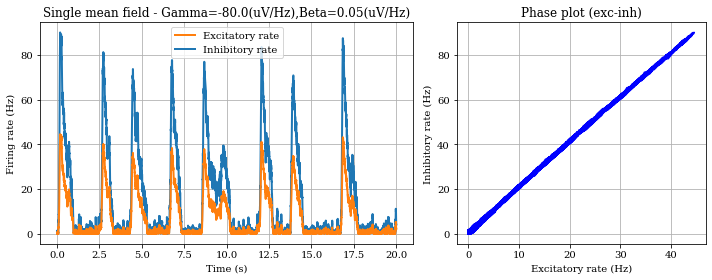

In [57]:
plot_single_p(time, solution, f"Single mean field - Gamma=-80.0(uV/Hz),Beta={beta_adapt/uV:.2f}(uV/Hz)", savefig="-80gamma_single.pdf")

If we change the noise_std_e the results mess up very quickly

In [58]:
# Plot phase diagram (standard model)
model = EIMeanField(tau_adapt=tau_adapt,
                beta_adapt=0.0, # beta_adapt to 0.0
                tau_e=tau_e,
                tau_i=tau_i,
                threshold_inh=threshold_inh0,
                noise_std_e=noise_e, # noise as well to 0
                noise_std_i=noise_e/4,
                f_ext=f_ext
                )
time, solution = run_single(model, gamma=0*uV)

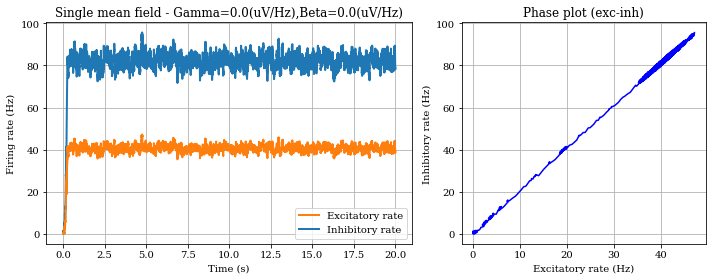

In [59]:
plot_single_p(time, solution, "Single mean field - Gamma=0.0(uV/Hz),Beta=0.0(uV/Hz)", savefig="0gamma_beta_single.pdf")

### Fixed point analysis

In [258]:
model = EIMeanField(tau_adapt=tau_adapt,
                beta_adapt=0.0, # beta_adapt to 0.0
                tau_e=tau_e,
                tau_i=tau_i,
                threshold_inh=threshold_inh0,
                noise_std_e=noise_e, # noise as well to 0
                noise_std_i=0,
                f_ext=f_ext
                )
time, solution = run_single(model, gamma=100*uV)

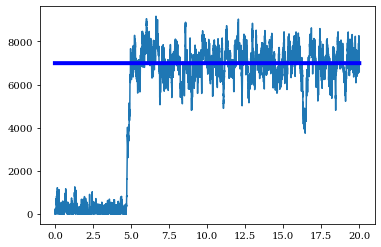

In [257]:
plt.plot(time, solution[:,0])
plt.plot(time, np.ones(solution[:,0].shape[0])*np.mean(solution[int(5.0/dt):,0]),lw=4., c='b')

In [262]:
# params
fn = "./results/fp_results.txt"
time = 40*s # (!)
gammas = np.linspace(-300,150,10)*uV
seeds = [100]

write(fn,"beta,gamma,seed,frequency,fp_e,fp_i\n",t="w")
for gamma in gammas:
    current = 0
    for seed in seeds:
        _ , solution = run_single(model, seed=seed, gamma=gamma, tmax=time)
        frequency = count_peaks(solution[:,0])/time
        fp_e = np.mean(solution[int(5.0/dt):,0])/model.n_e
        fp_i = np.mean(solution[int(5.0/dt):,1])/model.n_i

        write(fn,f"{beta}, {gamma}, {seed}, {frequency}, {fp_e}, {fp_i} \n")

        print(".", end="")
        #print(f"Gamma = {gamma/uV:2f} uV - Seed = {seed} - Frequency = {frequency} Hz")

    print(f"\nGamma = {gamma/uV:.3f} uV - Frequency (avg) = {current/10:.3f} Hz")

.
Gamma = -300.000 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -250.000 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -200.000 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -150.000 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -100.000 uV - Frequency (avg) = 0.000 Hz
.
Gamma = -50.000 uV - Frequency (avg) = 0.000 Hz
.
Gamma = 0.000 uV - Frequency (avg) = 0.000 Hz
.
Gamma = 50.000 uV - Frequency (avg) = 0.000 Hz
.
Gamma = 100.000 uV - Frequency (avg) = 0.000 Hz
.
Gamma = 150.000 uV - Frequency (avg) = 0.000 Hz


In [263]:
file_name = "./results/fp_results.txt"
results = pd.read_csv(file_name)

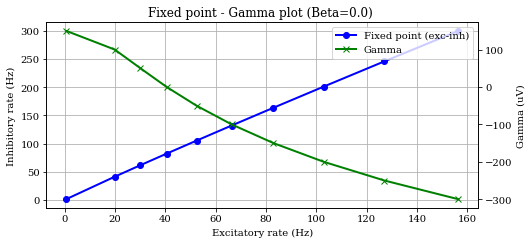

In [277]:
fig, ax = plt.subplots(figsize=(7.5,3.5))

l1 = ax.plot(results['fp_e'], results['fp_i'], 'o-', label="Fixed point (exc-inh)", lw=2.0, c='b')[0]
ax2 = ax.twinx()
l2 = ax2.plot(results['fp_e'], results['gamma']/uV, 'x-', label="Gamma", lw=2.0, c='green')[0]

lines = [l1,l2]

ax.legend(lines, [l.get_label() for l in lines],loc=1)
ax.set(title=f"Fixed point - Gamma plot (Beta=0.0) ",
       xlabel="Excitatory rate (Hz)",
       ylabel="Inhibitory rate (Hz)")
ax2.set(ylabel="Gamma (uV)")
ax.grid()

fig.tight_layout()

fig.show()
fig.savefig('./img/fp-gamma.pdf', dpi=300)

### Changing external current

In [39]:
# parameters and init
model_params = {
'tau_adapt': 800 * ms, # adaptation time constant
'beta_adapt': beta_adapt, # strength of adaptation (per firing rate of E population)
'tau_e': 10*ms, # time constant of excitatory population
'tau_i': 5* ms, # time constant of inhibitory population
'threshold_inh': -51 * mV, # inhibitory threshold
'noise_std_e': noise_e, 
'noise_std_i': noise_e,
'f_ext': 1000 * Hz,
}

model = EIMeanField(**model_params)

In [40]:
def run_single_gamma(model,  gamma_signal, seed=100, rexc_i=100*Hz, rinh_i=100*Hz, theta_i=0*mV, dt=1*ms, tmax=20*s):
    if int(tmax/dt) != gamma_signal.shape[0]:
        raise Exception(f"gamma_signal has wrong size: {gamma_signal.shape[0]} vs {int(tmax/dt)}")
    
    np.random.seed(seed)
    
    rexc = rexc_i
    rinh = rinh_i
    theta = theta_i
    
    t = 0
    solution = []
    while t < tmax:
        rexc, rinh, theta = model.sde_step(dt, rexc, rinh, theta, gamma_signal[int(t/dt)])
        t += dt
        solution.append((rexc, rinh, theta))
    solution = np.array(solution)
    time = np.arange(solution.shape[0]) * dt
    
    return time, solution

In [41]:
def square(t, val, period, duty=0.5, invert=False):
    gamma = np.ones((int(t/dt)))*val
    for i in range(gamma.shape[0]):
        if invert:
            if (i*dt%period-period*duty) < 0.0: gamma[i] = 0.0
        else:
            if (i*dt%period-period*duty) > 0.0: gamma[i] = 0.0
    return gamma

In [42]:
t = 40.0*s
gamma1 = square(t, 150*uV, period=20.0)
time, solution1 = run_single_gamma(model, gamma_signal=gamma1, tmax=t)

In [47]:
# plot
def plot_single_gamma(time, solution, gamma, title, ax=None, savefig=None, size=(7.5,3)):
    if not ax:
        fig, ax = plt.subplots(figsize=size)
    fig = False
    
    ilast = min(time.shape[0], solution.shape[0], gamma.shape[0])
    
    l2 = ax.plot(time[:ilast], solution[:ilast,1]/model.n_i, label="Inhibitory rate", lw=2.0)[0]
    l1 = ax.plot(time[:ilast], solution[:ilast,0]/model.n_e, label="Excitatory rate", lw=2.0)[0]

    ax2 = ax.twinx()
    # ax2.set_ylim([0.0,0.00025])
    l3 = ax2.plot(time[:ilast], gamma[:ilast], label="$U_{ext}$ ($\mu V$)", lw=2.0,alpha=1., c='b')[0]

    lines = [l1,l2,l3]

    ax.legend(lines, [l.get_label() for l in lines], loc=1)
    ax.set(title=title,
           xlabel="Time (s)",
           ylabel="Firing rate (Hz)")
    ax2.set(ylabel=r"$U_{ext}$ ($\mu V$)")
    ax.grid()
    

    if fig:
        fig.tight_layout()

        fig.show()

        if savefig:
            fig.savefig(f'./img/{savefig}', dpi=300)
    

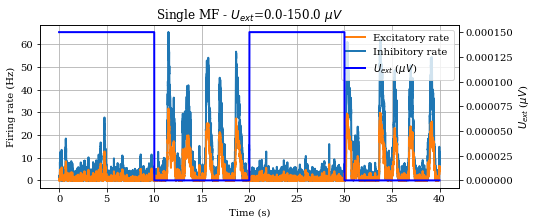

In [48]:
plot_single_gamma(time, solution1, gamma1, title=r'Single MF - $U_{ext}$=0.0-150.0 $\mu V$',savefig='squaregamma1_single.pdf')

In [50]:
# parameters and init
model_params = {
'tau_adapt': 800 * ms, # adaptation time constant
'beta_adapt': 0.014*uV, # strength of adaptation (per firing rate of E population)
'tau_e': 10*ms, # time constant of excitatory population
'tau_i': 5* ms, # time constant of inhibitory population
'threshold_inh': -51 * mV, # inhibitory threshold
'noise_std_e': noise_e, 
'noise_std_i': noise_e/4,
'f_ext': 1000 * Hz,
}

model = EIMeanField(**model_params)

t = 120.0*s
gamma2 = square(t, 45*uV, period=40.0, invert=True, duty=0.2)
time, solution2 = run_single_gamma(model, gamma_signal=gamma2, tmax=t)

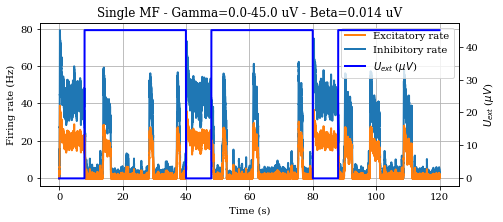

In [51]:
plot_single_gamma(time, solution2, gamma2/uV, title=f'Single MF - Gamma=0.0-{45.} uV - Beta=0.014 uV',savefig='squaregamma2_single.pdf')

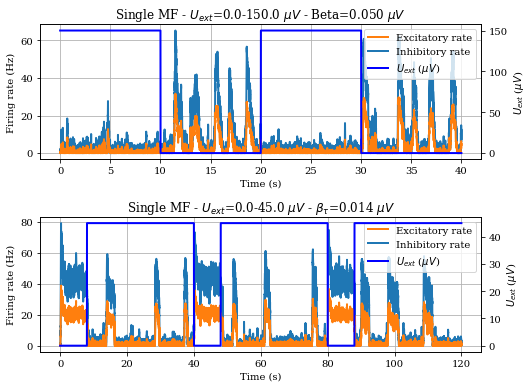

In [54]:
fig, ax = plt.subplots(2,1, figsize=(7.5,5.5))
plot_single_gamma(time, solution1, gamma1/uV, ax=ax[0], title=r'Single MF - $U_{ext}$=0.0-150.0 $\mu V$ - Beta=0.050 $\mu V$',savefig='squaregamma1_single.pdf')
plot_single_gamma(time, solution2, gamma2/uV, ax=ax[1], title=r'Single MF - $U_{ext}$=0.0-45.0 $\mu V$ - $\beta_\tau$=0.014 $\mu V$',savefig='squaregamma2_single.pdf')

fig.tight_layout()
fig.savefig(f'./img/alternating.pdf', dpi=300)

### Oscillating gamma

In [100]:
noise_e

2000.0

In [92]:
# parameters and init
model_params = {
'tau_adapt': 800 * ms, # adaptation time constant
'beta_adapt': beta_adapt, # strength of adaptation (per firing rate of E population)
'tau_e': 10*ms, # time constant of excitatory population
'tau_i': 5* ms, # time constant of inhibitory population
'threshold_inh': -51 * mV, # inhibitory threshold
'noise_std_e': noise_e, 
'noise_std_i': noise_e/4,
'f_ext': 1000 * Hz,
}

model = EIMeanField(**model_params)

In [55]:
def run_single_gamma(model,  gamma_signal, seed=100, rexc_i=100*Hz, rinh_i=100*Hz, theta_i=0*mV, dt=1*ms, tmax=20*s):
    if int(tmax/dt) != gamma_signal.shape[0]:
        raise Exception(f"gamma_signal has wrong size: {gamma_signal.shape[0]} vs {int(tmax/dt)}")
    
    np.random.seed(100)
    
    rexc = rexc_i
    rinh = rinh_i
    theta = theta_i
    
    t = 0
    solution = []
    while t < tmax:
        rexc, rinh, theta = model.sde_step(dt, rexc, rinh, theta, gamma_signal[int(t/dt)])
        t += dt
        solution.append((rexc, rinh, theta))
    solution = np.array(solution)
    time = np.arange(solution.shape[0]) * dt
    
    return time, solution

In [56]:
def square(t, val, period, duty=0.5, invert=False):
    gamma = np.ones((int(t/dt)))*val
    for i in range(gamma.shape[0]):
        if invert:
            if (i*dt%period-period*duty) < 0.0: gamma[i] = 0.0
        else:
            if (i*dt%period-period*duty) > 0.0: gamma[i] = 0.0
    return gamma

In [57]:
# plot
def plot_single_gamma(time, solution, gamma, alpha=0.2, title="Default", savefig=None):
    fig, ax = plt.subplots(figsize=(7.5,4))
    l2 = ax.plot(time, solution[:,1]/model.n_i, label="Inhibitory rate", lw=2.0)[0]
    l1 = ax.plot(time, solution[:,0]/model.n_e, label="Excitatory rate", lw=2.0)[0]

    ax2 = ax.twinx()
    # ax2.set_ylim([0.0,0.00025])
    l3 = ax2.plot(time[:], gamma, label="Gamma (uV)", lw=1.0,alpha=alpha, c='b')[0]

    lines = [l1,l2,l3]

    ax.legend(lines, [l.get_label() for l in lines], loc=1)
    ax.set(title=title,
           xlabel="Time (s)",
           ylabel="Firing rate (Hz)")
    ax2.set(ylabel="External gamma (uV)")
    ax.grid()
    
    fig.tight_layout()

    fig.show()

    if savefig:
        fig.savefig(f'./img/{savefig}', dpi=300)
    

In [174]:
t = 40.0*s
f = 1*Hz
#gamma = square(t, 150*uV, period=20.0)
gamma = np.sin(np.linspace(-np.pi, np.pi, int(t/dt))*f*t)*100*uV-50*uV
time, solution = run_single_gamma(model, gamma_signal=gamma, tmax=t)

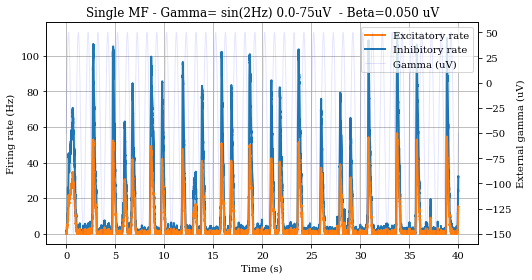

In [175]:
plot_single_gamma(time[:int(40/dt)], solution[:int(40/dt),:], gamma[:int(40/dt)]/uV, alpha=0.1, title=f'Single MF - Gamma= sin(2Hz) 0.0-75uV  - Beta=0.050 uV',savefig='exp.pdf')
print(count_peaks(solution[:,0])/t)

Running the experiments

In [206]:
# params
fn = "./results/f0mean_results.txt"
t = 400*s # (!)
freqs = np.linspace(0,100,15)
amps = np.linspace(0,200,8)
seeds = [100]
beta = beta_adapt

write(fn,"beta,gamma_freq,gamma_amp,gamma_mean,frequency\n",t="w")
for freq in freqs:
    results = []
    for amp in amps:
        # computations
        gamma = np.sin(np.linspace(-np.pi, np.pi, int(t/dt))*freq*t)*amp*uV+0*uV    # Oscillating 0 mean sinus
        _ , solution = run_single_gamma(model, gamma_signal=gamma, tmax=t)        
        frequency = count_peaks(solution[:,0])/t
        
        results.append(frequency)   # ouput logging
        write(fn,f"{beta}, {freq}, {amp}, 0, {frequency}\n") # storing results
        print(".", end="")

    print(f"\nGamma = {freq:.1f} Hz 0-200 uV - Frequency (avg) = {np.mean(results):.3f} Hz")

........
Gamma = 0.0 Hz 0-200 uV - Frequency (avg) = 0.260 Hz
........
Gamma = 7.1 Hz 0-200 uV - Frequency (avg) = 0.326 Hz
........
Gamma = 14.3 Hz 0-200 uV - Frequency (avg) = 0.289 Hz
........
Gamma = 21.4 Hz 0-200 uV - Frequency (avg) = 0.280 Hz
........
Gamma = 28.6 Hz 0-200 uV - Frequency (avg) = 0.281 Hz
........
Gamma = 35.7 Hz 0-200 uV - Frequency (avg) = 0.287 Hz
........
Gamma = 42.9 Hz 0-200 uV - Frequency (avg) = 0.275 Hz
........
Gamma = 50.0 Hz 0-200 uV - Frequency (avg) = 0.282 Hz
........
Gamma = 57.1 Hz 0-200 uV - Frequency (avg) = 0.278 Hz
........
Gamma = 64.3 Hz 0-200 uV - Frequency (avg) = 0.274 Hz
........
Gamma = 71.4 Hz 0-200 uV - Frequency (avg) = 0.279 Hz
........
Gamma = 78.6 Hz 0-200 uV - Frequency (avg) = 0.274 Hz
........
Gamma = 85.7 Hz 0-200 uV - Frequency (avg) = 0.278 Hz
........
Gamma = 92.9 Hz 0-200 uV - Frequency (avg) = 0.274 Hz
........
Gamma = 100.0 Hz 0-200 uV - Frequency (avg) = 0.274 Hz


In [85]:
file_name = "./results/f0mean_results.txt"
results = pd.read_csv(file_name)

In [86]:
results.head()

,beta,gamma_freq,gamma_amp,gamma_mean,frequency
0,5.000000e-08,0.0,0.000000,0,0.26
1,5.000000e-08,0.0,28.571429,0,0.26
2,5.000000e-08,0.0,57.142857,0,0.26
3,5.000000e-08,0.0,85.714286,0,0.26
4,5.000000e-08,0.0,114.285714,0,0.26


In [87]:
arr1 = results.frequency.values
mat1 = arr1.reshape(15,8)
fre1 = results.gamma_freq[::15].values
amp1 = results.gamma_amp[:8].values

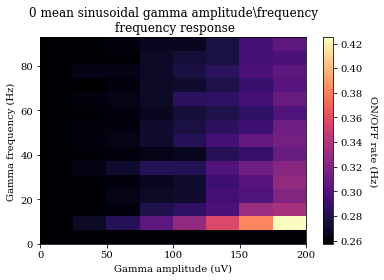

In [88]:
fig, ax = plt.subplots(figsize=(5.5,4.0))

c = ax.matshow(mat1, 
          cmap="magma",
          extent=[amp1.min(),amp1.max(),fre1.min(),fre1.max()],
          origin='lower',
          aspect="auto")

cbar = fig.colorbar(c, ax = ax)
cbar.ax.set_ylabel('ON/OFF rate (Hz)', labelpad=+15, rotation=270)

ax.set(title=f"0 mean sinusoidal gamma amplitude\\frequency\n frequency response",
       xlabel="Gamma amplitude (uV)",
       ylabel="Gamma frequency (Hz)")

fig.gca().xaxis.tick_bottom()


fig.show()
fig.tight_layout()

fig.savefig('./img/0mean_amp-freq_freq.pdf', dpi=300)

In [305]:
# params
fn = "./results/f0mean_close_results.txt"
t = 400*s # (!)
freqs = np.linspace(0,8,120)
seeds = [100,1000,10000,20000,30000]
beta = beta_adapt

write(fn,"beta,seed,gamma_freq,gamma_amp,gamma_mean,frequency\n",t="w")
for seed in seeds:
    for freq in freqs:
        # computations
        gamma = np.sin(np.linspace(-np.pi, np.pi, int(t/dt))*freq*t)*100*uV+0*uV    # Oscillating 0 mean sinus
        _ , solution = run_single_gamma(model, gamma_signal=gamma, tmax=t, seed=seed)        
        frequency = count_peaks(solution[:,0])/t

        write(fn,f"{beta}, {seed}, {freq}, 100, 0, {frequency}\n") # storing results
        print(".", end="")



........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [75]:
file_name = "./results/f0mean_close_results.txt"
results = pd.read_csv(file_name)

In [76]:
results.shape

(600, 6)

In [77]:
results.iloc[119::120]

,beta,seed,gamma_freq,gamma_amp,gamma_mean,frequency
119,5.000000e-08,100,8.0,100,0,0.285
239,5.000000e-08,1000,8.0,100,0,0.265
359,5.000000e-08,10000,8.0,100,0,0.295
479,5.000000e-08,20000,8.0,100,0,0.300
599,5.000000e-08,30000,8.0,100,0,0.280


In [78]:
freqs = results.frequency.values
gamma_freq = results.gamma_freq.values[:120]
avg_freqs = []
for i in range(120): # the number of seeds
    avg = np.mean(freqs[i::120])
    avg_freqs.append(avg)

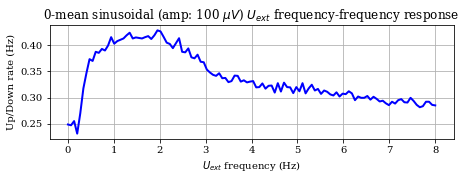

In [84]:
fig, ax = plt.subplots(figsize=(6.5,2.6))

ax.plot(gamma_freq, avg_freqs, c="b", lw=2.0)

ax.set(title=r"0-mean sinusoidal (amp: 100 $\mu V$) $U_{ext}$ frequency-frequency response",
       xlabel=r"$U_{ext}$ frequency (Hz)",
       ylabel="Up/Down rate (Hz)")

ax.grid()

fig.show()
fig.tight_layout()

fig.savefig('./img/0mean_close_freq_freq.pdf', dpi=300)

In [208]:
# params
fn = "./results/fposmean_results.txt"
t = 400*s # (!)
freqs = np.linspace(0,100,15)
amps = np.linspace(0,200,8)
seeds = [100]
beta = beta_adapt

write(fn,"beta,gamma_freq,gamma_amp,gamma_mean,frequency\n",t="w")
for freq in freqs:
    results = []
    for amp in amps:
        # computations
        gamma = np.sin(np.linspace(-np.pi, np.pi, int(t/dt))*freq*t)*amp*uV+amp/2*uV    # Oscillating 0 mean sinus
        _ , solution = run_single_gamma(model, gamma_signal=gamma, tmax=t)        
        frequency = count_peaks(solution[:,0])/t
        
        results.append(frequency)   # ouput logging
        write(fn,f"{beta}, {freq}, {amp}, {amp/2}, {frequency}\n") # storing results
        print(".", end="")

    print(f"\nGamma = {freq:.1f} Hz 0-200 uV - Frequency (avg) = {np.mean(results):.3f} Hz")

........
Gamma = 0.0 Hz 0-200 uV - Frequency (avg) = 0.098 Hz
........
Gamma = 7.1 Hz 0-200 uV - Frequency (avg) = 0.122 Hz
........
Gamma = 14.3 Hz 0-200 uV - Frequency (avg) = 0.107 Hz
........
Gamma = 21.4 Hz 0-200 uV - Frequency (avg) = 0.104 Hz
........
Gamma = 28.6 Hz 0-200 uV - Frequency (avg) = 0.107 Hz
........
Gamma = 35.7 Hz 0-200 uV - Frequency (avg) = 0.105 Hz
........
Gamma = 42.9 Hz 0-200 uV - Frequency (avg) = 0.103 Hz
........
Gamma = 50.0 Hz 0-200 uV - Frequency (avg) = 0.105 Hz
........
Gamma = 57.1 Hz 0-200 uV - Frequency (avg) = 0.104 Hz
........
Gamma = 64.3 Hz 0-200 uV - Frequency (avg) = 0.103 Hz
........
Gamma = 71.4 Hz 0-200 uV - Frequency (avg) = 0.104 Hz
........
Gamma = 78.6 Hz 0-200 uV - Frequency (avg) = 0.104 Hz
........
Gamma = 85.7 Hz 0-200 uV - Frequency (avg) = 0.102 Hz
........
Gamma = 92.9 Hz 0-200 uV - Frequency (avg) = 0.101 Hz
........
Gamma = 100.0 Hz 0-200 uV - Frequency (avg) = 0.102 Hz


In [70]:
file_name = "./results/fposmean_results.txt"
results = pd.read_csv(file_name)

In [71]:
results.head()

,beta,gamma_freq,gamma_amp,gamma_mean,frequency
0,5.000000e-08,0.0,0.000000,0.000000,0.2600
1,5.000000e-08,0.0,28.571429,14.285714,0.2050
2,5.000000e-08,0.0,57.142857,28.571429,0.1625
3,5.000000e-08,0.0,85.714286,42.857143,0.0975
4,5.000000e-08,0.0,114.285714,57.142857,0.0350


In [72]:
arr2 = results.frequency.values
mat2 = arr2.reshape(15,8)
fre2 = results.gamma_freq[::15].values
amp2 = results.gamma_amp[:8].values

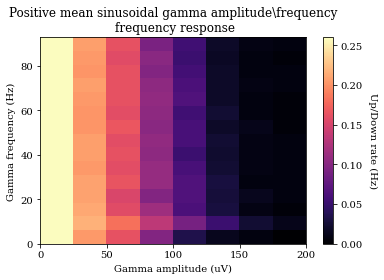

In [74]:
fig, ax = plt.subplots(figsize=(5.5,4.0))

c = ax.matshow(mat2, 
          cmap="magma",
          extent=[amp2.min(),amp2.max(),fre2.min(),fre2.max()],
          origin='lower',
          aspect="auto")

cbar = fig.colorbar(c, ax = ax)
cbar.ax.set_ylabel('Up/Down rate (Hz)', labelpad=+15, rotation=270)


ax.set(title=f"Positive mean sinusoidal gamma amplitude\\frequency\n frequency response",
       xlabel="Gamma amplitude (uV)",
       ylabel="Gamma frequency (Hz)")

fig.gca().xaxis.tick_bottom()


fig.show()
fig.tight_layout()

fig.savefig('./img/posmean_amp-freq_freq.pdf', dpi=300)

In [209]:
# params
fn = "./results/fnegmean_results.txt"
t = 400*s # (!)
freqs = np.linspace(0,100,15)
amps = np.linspace(0,200,8)
seeds = [100]
beta = beta_adapt

write(fn,"beta,gamma_freq,gamma_amp,gamma_mean,frequency\n",t="w")
for freq in freqs:
    results = []
    for amp in amps:
        # computations
        gamma = np.sin(np.linspace(-np.pi, np.pi, int(t/dt))*freq*t)*amp*uV-amp/2*uV    # Oscillating 0 mean sinus
        _ , solution = run_single_gamma(model, gamma_signal=gamma, tmax=t)        
        frequency = count_peaks(solution[:,0])/t
        
        results.append(frequency)   # ouput logging
        write(fn,f"{beta}, {freq}, {amp}, {-amp/2}, {frequency}\n") # storing results
        print(".", end="")

    print(f"\nGamma = {freq:.1f} Hz 0-200 uV - Frequency (avg) = {np.mean(results):.3f} Hz")

........
Gamma = 0.0 Hz 0-200 uV - Frequency (avg) = 0.402 Hz
........
Gamma = 7.1 Hz 0-200 uV - Frequency (avg) = 0.454 Hz
........
Gamma = 14.3 Hz 0-200 uV - Frequency (avg) = 0.439 Hz
........
Gamma = 21.4 Hz 0-200 uV - Frequency (avg) = 0.423 Hz
........
Gamma = 28.6 Hz 0-200 uV - Frequency (avg) = 0.412 Hz
........
Gamma = 35.7 Hz 0-200 uV - Frequency (avg) = 0.415 Hz
........
Gamma = 42.9 Hz 0-200 uV - Frequency (avg) = 0.413 Hz
........
Gamma = 50.0 Hz 0-200 uV - Frequency (avg) = 0.412 Hz
........
Gamma = 57.1 Hz 0-200 uV - Frequency (avg) = 0.410 Hz
........
Gamma = 64.3 Hz 0-200 uV - Frequency (avg) = 0.412 Hz
........
Gamma = 71.4 Hz 0-200 uV - Frequency (avg) = 0.411 Hz
........
Gamma = 78.6 Hz 0-200 uV - Frequency (avg) = 0.411 Hz
........
Gamma = 85.7 Hz 0-200 uV - Frequency (avg) = 0.407 Hz
........
Gamma = 92.9 Hz 0-200 uV - Frequency (avg) = 0.410 Hz
........
Gamma = 100.0 Hz 0-200 uV - Frequency (avg) = 0.412 Hz


In [66]:
file_name = "./results/fnegmean_results.txt"
results = pd.read_csv(file_name)

In [67]:
results.head()

,beta,gamma_freq,gamma_amp,gamma_mean,frequency
0,5.000000e-08,0.0,0.000000,-0.000000,0.2600
1,5.000000e-08,0.0,28.571429,-14.285714,0.3075
2,5.000000e-08,0.0,57.142857,-28.571429,0.3450
3,5.000000e-08,0.0,85.714286,-42.857143,0.3825
4,5.000000e-08,0.0,114.285714,-57.142857,0.4350


In [68]:
arr3 = results.frequency.values
mat3 = arr3.reshape(15,8)
fre3 = results.gamma_freq[::15].values
amp3 = results.gamma_amp[:8].values

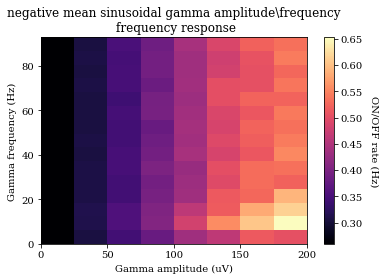

In [69]:
fig, ax = plt.subplots(figsize=(5.5,4.0))

c = ax.matshow(mat3, 
          cmap="magma",
          extent=[amp3.min(),amp3.max(),fre3.min(),fre3.max()],
          origin='lower',
          aspect="auto")

cbar = fig.colorbar(c, ax = ax)
cbar.ax.set_ylabel('ON/OFF rate (Hz)', labelpad=+15, rotation=270)

ax.set(title=f"negative mean sinusoidal gamma amplitude\\frequency\n frequency response",
       xlabel="Gamma amplitude (uV)",
       ylabel="Gamma frequency (Hz)")

fig.gca().xaxis.tick_bottom()


fig.show()
fig.tight_layout()

fig.savefig('./img/negmean_amp-freq_freq.pdf', dpi=300)

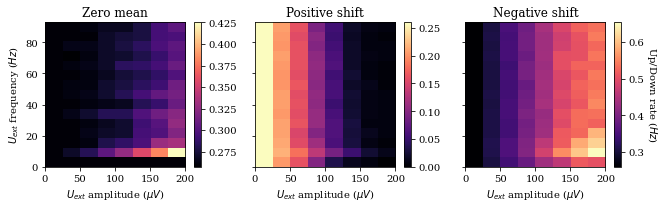

In [91]:
fig, ax = plt.subplots(1,3,figsize=(9.5,3.0), sharey="row")

c = ax[0].matshow(mat1, 
          cmap="magma",
          extent=[amp1.min(),amp1.max(),fre1.min(),fre1.max()],
          origin='lower',
          aspect="auto")
fig.gca().xaxis.tick_bottom()

fig.colorbar(c, ax = ax[0])
#cbar.ax.set_ylabel('ON/OFF rate (Hz)', labelpad=+15, rotation=270)

ax[0].set(title=f"Zero mean",
       xlabel=r"$U_{ext}$ amplitude ($\mu V$)",
       ylabel=r"$U_{ext}$ frequency ($Hz$)")

c = ax[1].matshow(mat2, 
          cmap="magma",
          extent=[amp2.min(),amp2.max(),fre2.min(),fre2.max()],
          origin='lower',
          aspect="auto")

cbar = fig.colorbar(c, ax = ax[1])
#cbar.ax.set_ylabel('ON/OFF rate (Hz)', labelpad=+15, rotation=270)

fig.gca().xaxis.tick_bottom()



ax[1].set(title=f"Positive shift",
       xlabel="$U_{ext}$ amplitude ($\mu V$)")
       #ylabel="Gamma frequency (Hz)")

c = ax[2].matshow(mat3, 
          cmap="magma",
          extent=[amp3.min(),amp3.max(),fre3.min(),fre3.max()],
          origin='lower',
          aspect="auto")

cbar = fig.colorbar(c, ax = ax[2])
cbar.ax.set_ylabel(r'Up/Down rate ($Hz$)', labelpad=+15, rotation=270)

ax[2].set(title=f"Negative shift",
       xlabel=r"$U_{ext}$ amplitude ($\mu V$)")
       #ylabel="Gamma frequency (Hz)")

#cbar = fig.colorbar(c, ax=ax.ravel().tolist(), shrink=1)

#cbar.set_ticks(np.arange(0, 1.1, 0.5))
#cbar.set_ticklabels(['low', 'medium', 'high'])

#fig.gca().xaxis.tick_bottom()
ax[0].xaxis.set_ticks_position('bottom')
ax[1].xaxis.set_ticks_position('bottom')
ax[2].xaxis.set_ticks_position('bottom')


fig.show()
fig.tight_layout()



fig.savefig('./img/together.pdf', dpi=300)